In [1]:
import sys
import torch  
import gym
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt

# REINFORCE BASELINE VALUE FUNCTION

In [2]:
# Constants
GAMMA = 0.99

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(Variable(state))
        #Choose action with regard to policy
        highest_prob_action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[highest_prob_action]) #log for gradient
        return highest_prob_action, log_prob

In [3]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(ValueNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, 1)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.linear1(state))
        value = self.linear2(value)
        return value

In [4]:
def update_policy(policy_network, trajectories_gradient):
    policy_network.optimizer.zero_grad()    
    policy_gradient = torch.stack(trajectories_gradient).sum()
    policy_gradient.backward()
    policy_network.optimizer.step()

In [5]:
def count_trajectory(rewards, log_probs, baseline, policy_learning = False):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob, Gt, bs in zip(log_probs, discounted_rewards, baseline):
        if log_prob == 0:
            policy_gradient.append(torch.tensor([[0.0]], requires_grad = True))
        else:
            policy_gradient.append(-log_prob * (Gt - bs))
    
    if policy_learning:
        policy_gradient = torch.stack(policy_gradient).sum()
    return policy_gradient

In [6]:
def align_columns_zeros(array):
    max_length = max(list(map(lambda x: len(x), array)))
    for col in range(len(array)):
        array[col] = np.pad(array[col], max_length - len(array[col]), 'constant', constant_values = 0)[max_length - len(array[col]):]
    return array

In [7]:
def baseline_approximation(policy_net, value_net, val_optimizer, n_trajectories, n_epoch = 4000, early_stopping_rounds = 250):
    max_steps = 10000
    min_loss = float('inf')
    stopping_rounds = 0
    epoch = 1
    while(stopping_rounds < early_stopping_rounds and epoch < n_epoch):
        r_gradient = []
        rewards = [[] for i in range(n_trajectories)]
        log_probs = [[] for i in range(n_trajectories)]
        baseline_values = [[] for i in range(n_trajectories)]
    
        for trajectory in range(n_trajectories):
            state = env.reset()
            
            for steps in range(max_steps):
                baseline = value_net.forward(state)
                action, log_prob = policy_net.get_action(state)
                new_state, reward, done, _ = env.step(action)
                baseline_values[trajectory].append(baseline)
                log_probs[trajectory].append(log_prob)
                rewards[trajectory].append(reward)
                if done:                    
                    break
                state = new_state
        rewards = align_columns_zeros(rewards)
        log_probs = align_columns_zeros(log_probs)
        baseline_values = align_columns_zeros(baseline_values)
        for col in range(len(rewards)):
            traj = count_trajectory(rewards[col], log_probs[col], baseline_values[col])
            r_gradient.append(traj)
            
        r_gradient = list(map(lambda x: torch.stack(x), r_gradient))
        r_gradient = torch.stack(r_gradient)
        
        value_loss = torch.var(r_gradient, 1).sum()
        if value_loss < min_loss:
            min_loss = value_loss
            torch.save(value_net, 'model.pth')
            print('{}. Current minimum value loss = {}'.format(epoch, value_loss))
            stopping_rounds = 0
        else:
            stopping_rounds += 1
        #print('{}. Value loss = {}, early stopping rounds = {}'.format(epoch, value_loss, stopping_rounds))
        epoch += 1
        val_optimizer.zero_grad()
        value_loss.backward()
        val_optimizer.step()
    value_net = torch.load('model.pth')

In [13]:
def cart_pole_baseline(value_net, n_trajectories = 2, episode_num = 1500, baseline_retrain = False, retrain_episodes = 50):
    env = gym.make('CartPole-v0')
    policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 256)
    

    max_episode_num = episode_num
    max_steps = 10000
    numsteps = [[] for i in range(n_trajectories)]
    avg_numsteps = [[] for i in range(n_trajectories)]
    all_rewards = [[] for i in range(n_trajectories)]

    for episode in range(1, max_episode_num + 1):
        r_gradient = []
        rewards = [[] for i in range(n_trajectories)]
        baseline_values = []
        
        for trajectory in range(n_trajectories):
            state = env.reset()
            log_probs = []
            
            for steps in range(max_steps):
                #env.render()
                baseline = value_net.forward(state)
                action, log_prob = policy_net.get_action(state)
                new_state, reward, done, _ = env.step(action)
                log_probs.append(log_prob)
                rewards[trajectory].append(reward)
                baseline_values.append(baseline)
                
                if done:
                    traj = count_trajectory(rewards[trajectory], log_probs, baseline_values, True)                       
                    r_gradient.append(traj)
                    numsteps[trajectory].append(steps)
                    avg_numsteps[trajectory].append(np.mean(numsteps[trajectory][-10:]))
                    all_rewards[trajectory].append(np.sum(rewards[trajectory]))
                    break

                state = new_state
                
        update_policy(policy_net, r_gradient)                 
        rewards = align_columns_zeros(rewards)
        #print(all_rewards)
        if episode % 10 == 0:
            sys.stdout.write("episode: {}, total mean reward among trajectories: {}, average_reward_among_trajectories: {}\n".\
                                     format(episode, np.round(np.mean(np.sum(rewards, axis = 1)), decimals = 3),\
                                            np.round(np.mean(np.mean(all_rewards, axis = 0)[-10:]), decimals = 3)))
            
        if baseline_retrain == True:
            if episode % retrain_episodes == 0:
                baseline_approximation(policy_net, value_net, val_optimizer, 3, n_epoch = 1000, early_stopping_rounds=10)
        
    return all_rewards, avg_numsteps 

In [14]:
%%time
env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 256)
value_net = ValueNetwork(env.observation_space.shape[0], env.action_space.n, 256)
val_optimizer = optim.Adam(value_net.parameters(), lr=3e-4)
baseline_approximation(policy_net, value_net, val_optimizer, 3, early_stopping_rounds=300)

D:\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ValueNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1. Current minimum value loss = 1.0817387104034424
2. Current minimum value loss = 1.0429147481918335
5. Current minimum value loss = 0.9826594591140747
7. Current minimum value loss = 0.940153956413269
13. Current minimum value loss = 0.9185212254524231
14. Current minimum value loss = 0.8809243440628052
16. Current minimum value loss = 0.8070756793022156
28. Current minimum value loss = 0.7866318225860596
54. Current minimum value loss = 0.7299036383628845
59. Current minimum value loss = 0.6481955051422119
65. Current minimum value loss = 0.6434944868087769
98. Current minimum value loss = 0.5985133647918701
128. Current minimum value loss = 0.5692092180252075
170. Current minimum value loss = 0.5492762327194214
171. Current minimum value loss = 0.42624300718307495
197. Current minimum value loss = 0.3594302535057068
216. Current minimum value loss = 0.35601943731307983
246. Current minimum value loss = 0.3036741018295288
289. Current minimum value loss = 0.27783671021461487
291. Cu

In [15]:
%%time
all_rewards, mean_rewards = cart_pole_baseline(value_net, 2, 2000, True, 10)

episode: 10, total mean reward among trajectories: 25.0, average_reward_among_trajectories: 25.45
1. Current minimum value loss = 0.4894123673439026
4. Current minimum value loss = 0.3327412009239197
8. Current minimum value loss = 0.2895969748497009
16. Current minimum value loss = 0.2633309066295624
episode: 20, total mean reward among trajectories: 17.0, average_reward_among_trajectories: 29.9
1. Current minimum value loss = 0.19558849930763245
episode: 30, total mean reward among trajectories: 23.0, average_reward_among_trajectories: 21.85
1. Current minimum value loss = 0.4791482985019684
10. Current minimum value loss = 0.36857396364212036
11. Current minimum value loss = 0.2799012064933777
episode: 40, total mean reward among trajectories: 18.0, average_reward_among_trajectories: 21.6
1. Current minimum value loss = 0.5185263156890869
2. Current minimum value loss = 0.3047350347042084
episode: 50, total mean reward among trajectories: 60.0, average_reward_among_trajectories: 29.

4. Current minimum value loss = 0.2950555682182312
7. Current minimum value loss = 0.20717623829841614
episode: 310, total mean reward among trajectories: 110.5, average_reward_among_trajectories: 95.4
1. Current minimum value loss = 0.47972458600997925
2. Current minimum value loss = 0.3588549494743347
3. Current minimum value loss = 0.28334301710128784
4. Current minimum value loss = 0.21110138297080994
episode: 320, total mean reward among trajectories: 129.5, average_reward_among_trajectories: 99.65
1. Current minimum value loss = 0.16397108137607574
episode: 330, total mean reward among trajectories: 130.0, average_reward_among_trajectories: 102.05
1. Current minimum value loss = 0.1288338154554367
7. Current minimum value loss = 0.1154736578464508
episode: 340, total mean reward among trajectories: 79.5, average_reward_among_trajectories: 97.75
1. Current minimum value loss = 0.4433952271938324
2. Current minimum value loss = 0.211518332362175
8. Current minimum value loss = 0.16

15. Current minimum value loss = 0.16754667460918427
episode: 600, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 170.1
1. Current minimum value loss = 0.2010284811258316
episode: 610, total mean reward among trajectories: 128.5, average_reward_among_trajectories: 173.25
1. Current minimum value loss = 0.4006071090698242
3. Current minimum value loss = 0.24876931309700012
6. Current minimum value loss = 0.16822116076946259
9. Current minimum value loss = 0.07580051571130753
episode: 620, total mean reward among trajectories: 183.5, average_reward_among_trajectories: 175.1
1. Current minimum value loss = 0.12813374400138855
episode: 630, total mean reward among trajectories: 143.0, average_reward_among_trajectories: 174.0
1. Current minimum value loss = 0.15412072837352753
11. Current minimum value loss = 0.11783882975578308
12. Current minimum value loss = 0.09531998634338379
episode: 640, total mean reward among trajectories: 121.0, average_reward_amon

1. Current minimum value loss = 0.4018760919570923
episode: 910, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 195.55
1. Current minimum value loss = 0.5436416268348694
2. Current minimum value loss = 0.46172505617141724
6. Current minimum value loss = 0.3545370101928711
9. Current minimum value loss = 0.303093820810318
episode: 920, total mean reward among trajectories: 142.5, average_reward_among_trajectories: 178.95
1. Current minimum value loss = 0.6506990194320679
2. Current minimum value loss = 0.6214426755905151
4. Current minimum value loss = 0.3609652519226074
12. Current minimum value loss = 0.30122238397598267
16. Current minimum value loss = 0.24899932742118835
episode: 930, total mean reward among trajectories: 163.5, average_reward_among_trajectories: 189.3
1. Current minimum value loss = 0.48664623498916626
2. Current minimum value loss = 0.26894888281822205
4. Current minimum value loss = 0.25877657532691956
7. Current minimum value los

1. Current minimum value loss = 0.5461580753326416
6. Current minimum value loss = 0.5236278772354126
12. Current minimum value loss = 0.2827530801296234
episode: 1200, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 198.05
1. Current minimum value loss = 1.1089508533477783
2. Current minimum value loss = 0.49951171875
3. Current minimum value loss = 0.4975201189517975
4. Current minimum value loss = 0.30417436361312866
episode: 1210, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 196.7
1. Current minimum value loss = 0.7667005658149719
5. Current minimum value loss = 0.3957759737968445
7. Current minimum value loss = 0.38262268900871277
episode: 1220, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 194.3
1. Current minimum value loss = 1.2270561456680298
2. Current minimum value loss = 0.7801154255867004
3. Current minimum value loss = 0.44167041778564453
12. Current minimum value loss = 0

1. Current minimum value loss = 0.29491108655929565
episode: 1490, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 195.6
1. Current minimum value loss = 0.586611270904541
5. Current minimum value loss = 0.22474166750907898
episode: 1500, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 190.35
1. Current minimum value loss = 0.647983968257904
5. Current minimum value loss = 0.5791577696800232
7. Current minimum value loss = 0.41652029752731323
9. Current minimum value loss = 0.24060362577438354
episode: 1510, total mean reward among trajectories: 199.0, average_reward_among_trajectories: 197.4
1. Current minimum value loss = 0.8676257133483887
2. Current minimum value loss = 0.28906917572021484
3. Current minimum value loss = 0.2155231237411499
episode: 1520, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 196.3
1. Current minimum value loss = 0.9800758361816406
2. Current minimum value loss =

5. Current minimum value loss = 0.4659367799758911
7. Current minimum value loss = 0.3893349766731262
17. Current minimum value loss = 0.32998672127723694
21. Current minimum value loss = 0.2542041540145874
episode: 1780, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 200.0
1. Current minimum value loss = 0.901498019695282
3. Current minimum value loss = 0.8469089865684509
5. Current minimum value loss = 0.8027751445770264
6. Current minimum value loss = 0.10300751030445099
episode: 1790, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 192.8
1. Current minimum value loss = 0.9786896109580994
2. Current minimum value loss = 0.27304190397262573
6. Current minimum value loss = 0.26856085658073425
episode: 1800, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 195.25
1. Current minimum value loss = 0.6017053723335266
2. Current minimum value loss = 0.4797601103782654
5. Current minimum value los

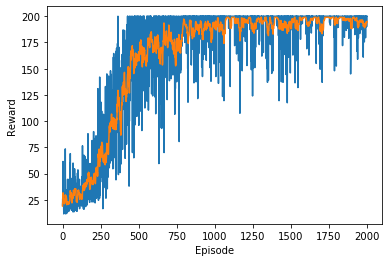

Varince of reward = 3354.229025


In [16]:
plt.plot(np.mean(all_rewards, axis = 0))
plt.plot(np.mean(mean_rewards, axis = 0))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('Varince of reward = {}'.format(np.var(np.mean(all_rewards, axis = 0))))

In [18]:
df = pd.DataFrame()
df['rewards'] = np.mean(all_rewards, axis = 0)
df['mean10_rewards'] = np.mean(mean_rewards, axis = 0)

In [19]:
df.to_csv('D:/Reinforcement_Learning/df_reinforce_2_trajectories_baseline_2000_retrain.csv', index=False)